<a href="https://colab.research.google.com/github/mknomics/teaching/blob/main/Dummy_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
%matplotlib inline 

In [23]:
def model(X=True, Y=True):
  reg_model = sm.GLS(Y, X).fit()
  #X = sm.add_constant(X,  has_constant='add')  This method did not work for me
  #predictions = reg_model.predict(X) This method can make predictions but we don't need them in this example
  print(reg_model.summary())
  return

## Load Data into Colab

In [3]:
house_data_path='https://raw.githubusercontent.com/data-doctors/kaggle-house-prices-advanced-regression-techniques/master/data/train.csv'
df_house=pd.read_csv(house_data_path) # invoke Pandas and use read_csv() method passing in the parameter of the csv location, in this case a url address
df_house.head(1) # Visually Inspect that it loaded correctly
#df_house.info() # info() is prefered to .dtypes method because info() gives null counts and dtypes and does not cut the output shortd

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


# Research Question
We are interested in exploring the determinants of house prices.  This dataset has a rich number of features to explore and we will only scratch the surface here.  This process is fundamentally different than the Predictive Analytics that we have done to date.  In Predictive Analytics, we are interested in making accurate predictions period.  Now we turn our attention away from the target variable $Y$ and focus on the coefficients $\beta$.  

We will only address two of the many dimensions in this data set:


1.   Square Footage
2.   Building Type

There are many "rocks left unturned" in this exercise.  But by the end of the exercise, you should be able to


1.   Create Dummy Variables and use them in a regression model
2.   Interpret the coefficients of dummy variables and the coefficients on dummy variables interacted with other independent variables $X$.  
3.   Understand how to use information to "question" the dataset, like a detective questions a suspect; building evidence that convinces you.  
4.   Tell a story using data:  You must convince yourself what is going on before you can convince others. 





## Preliminary Exploration

A first best step is always to scatter the data.  I purposefully chose one independent $X$ variable that is continuous (Square Foot) and another that is categorical (Building Type).  So let's start by scattering the continuous independent variable against the dependant variable $Y$, being SalePrice. 

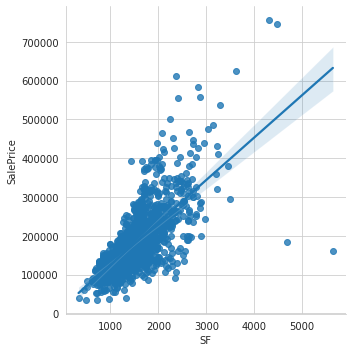

In [22]:
# Feature Engineer Total Square Foot
df_house['SF']=df_house['1stFlrSF']+df_house['2ndFlrSF'] 
df_house['constant']=1 # add a constant for later use in the regressions
sns.set_style('whitegrid')
sns.lmplot(x ='SF', y ='SalePrice', data = df_house)

## Interpretation
We clearly see a positive correlation between Total Square Footage and Sale Price in the scatter plot above.  


## Notice Any Data Abnomalities and Patterns

**Observation 1** There are a couple of outliers that have significant leverage in the data set.  Notice the two points in the bottom right quadrant.  Understand their effect using the following analogy:  Think of the regression line as if it were a teeter-totter or seesaw that is sitting on the mean of $X$, or Square Foot in our case.  Points that have a high error or distance from $\hat{Y}$, aka are far from the regression line, are like big kids sitting on the seesaw.  Points that are farther from the mean (center mass) of Square Foot are like kids sitting on the end of the seesaw, while points closer to the mean are like kids sitting near the middle of the seesaw.  

In our case, we have two very big kids sitting on the end of our seesaw, which has the effect of pulling the regression line downward, thus reducing the slope of the regression line.  

We will not address this here in this exercise but this point is just to bring awareness to a potential data issue and also bring awareness to the usefullness of scattering your data!!!

**Observation 2** The scatter also takes on a familiar cone shape.  Notice that the data "fans" outward towards the Northeast quadrant almost like a triangle.  This is a sign of what is technically called "heteroskedasticity", which is a fancy way of saying that the errors of a linear regression model are a function of $X$.  You can clearly see that the errors, $\epsilon_i = \hat{Y_i}-Y_i$ get larger as $X$ increases.  Look at $\hat{Y}$ in the graph, which is the regression line and notice that the distance between the the line and the scatter points is larger for larger values of $X$.  In this case Genaralized Least Squares (GLS) is preferred to Ordinary Least Squares (OLS). 

GLS is a more robust methodology than OLS for this reason. 

## Questioning the Data 

How might this relationship between Price and Square Footage change for different types of buildings?  

Let's scatter Square Foot and Sale Price but this time let us assign a different color to each type and also fit a separate regression line for each type.

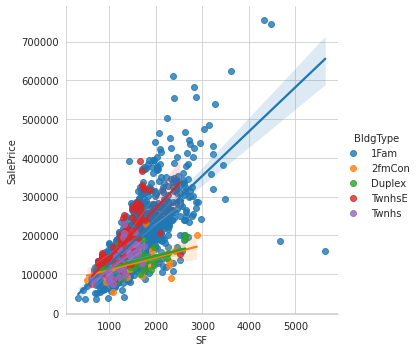

In [21]:
sns.set_style('whitegrid')
sns.lmplot(x ='SF', y ='SalePrice', data = df_house, 
           hue ='BldgType')

### Interpretation
We can clearly see that the correlation between Square Foot and SalePrice appears to differ by building type.  The regression lines seem to have different slopes.  Notably 2fmCon is much flatter while TwnhsE is steeper than 1Fam.  

# Mechanics of Creating Dummy Variables
Transform Categorical variables into "Dummy Variables".  Dummy Variables only take the value zero or one.  Lets consider the variable "BldgType" as an example.

Note the "BldgType" is an object datatype.  You can see this by typing:

```
df_house['BldgType'].dtype
```
This returns "O" for object, which we can easily see is a string that represents the type of building.  

How many categories does BldgType have?

Find this by typing:


```
df_house['BldgType'].unique()
```

Which returns: ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs']

BldgType has 5 categories and we create 5 new columns of data, with the string category as the column name.  The values of each column will be 1 if that row is equal to the column name and zero otherwise.  

For example:  Suppose the first 5 rows of df_house['BldgType'] were:

'1Fam'

'1Fam'

'Duplex'

'TwnhsE'

'1Fam'


The Dummy variables would be: 

'1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'

1       0          0         0         0

1       0          0         0         0

0       0          1         0         0

0       0          0         1         0

1       0          0         0         0

## get_dummies()

In [4]:
pd.get_dummies(df_house['BldgType'])

,1Fam,2fmCon,Duplex,Twnhs,TwnhsE
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
1455,1,0,0,0,0
1456,1,0,0,0,0
1457,1,0,0,0,0
1458,1,0,0,0,0


## join dummies to original df

In [5]:
df_house=pd.get_dummies(df_house['BldgType']).join(df_house)


In [6]:
df_house.head(2)

,1Fam,2fmCon,Duplex,Twnhs,TwnhsE,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,0,0,0,0,1,60,RL,65.0,8450,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,1,0,0,0,0,2,20,RL,80.0,9600,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


# Modeling with dummies

We can now include these dummies in our model. 

**Point 1**
WE MUST not include all categories of a given categorical variable. The reason is that the information of any given column must contain unique information.  If we include all categories then we violate this condition.  How?

Consider a simple categorical variable, "Gender" which takes on two values for this discussion sake, "Male" and "Female".  If we make a dummy variable for Male and Female then notice that 

Male = 1 - Female

In other words, if you give me either column then I can tell you what the value of the second column is without even looking at it.  Full information on Gender is contained in a single column so adding a second column gives no new information. 

The technical jargon is that (𝐗ᵀ𝐗)^-1 is full rank, meaning that no column is a linear combination of other columns.  

Bottom Line:  You always have to exclude one category when adding dummy variables to your model

**Point 2** and the dummy that you exclude should not be sparce (having only a few values of 1)

We can use the value_counts() method to check how many observations are in each category.  If you have multiple categories then it might be possible to pool some categories if you can do so in a meaningful way.  This is a common approach to dealing with sparce categories.  

If you violate this then be prepared for wild results even if your algorithm appears to run without error

In [7]:
pd.get_dummies(df_house['BldgType']).value_counts()

1Fam  2fmCon  Duplex  Twnhs  TwnhsE
1     0       0       0      0         1220
0     0       0       0      1          114
              1       0      0           52
              0       1      0           43
      1       0       0      0           31
dtype: int64

It seems that there are sufficient numbers in all categories, but barely so, since 2fmCon only has 31 observations.  We can increase the variability by grouping all categories, other than 1Fam, together into a single group.  

Let's explore the influence on total square feet and price and allow this influence to differ based on building type.  In other words we will create three categories:  1Fam, 2fmCon and Other

## Testing simple differences in means between groups
We can test if there are average differences, in terms of our "Y" variable by specifying a simple regression of the form:
$SalesPrice= \beta_0 + \beta_1\times D_{1Fam} +  \beta_2\times D_{2fmCon} + \epsilon$

**Interpretation:** 

$\beta_1$ is the average difference in SalesPrice between houses that are 1Fam versus those that are of the ommitted category, which in this case is the combination of (Duplex, Twnhs and TwnhsE).  

$\beta_2$ is the average difference in SalesPrice between houses that are 2fmCon versus those that are of the ommitted category, which in this case is the combination of (Duplex, Twnhs and TwnhsE).  


In [24]:
# Run model and interpret results
model(X=df_house[['constant','1Fam','2fmCon']], Y=df_house['SalePrice'])

                            GLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.022
Model:                            GLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     16.32
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           9.83e-08
Time:                        15:16:05   Log-Likelihood:                -18528.
No. Observations:                1460   AIC:                         3.706e+04
Df Residuals:                    1457   BIC:                         3.708e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant    1.604e+05   5438.363     29.501      0.0

### Interpretation:
The coefficient on 1Fam is 25,330 and is significant at the 99% Confidence level meaning that 1Fam houses cost $25,330 more than the "other" category on avarage.

The coefficient on 2fmCon is -32,010 and is significant at the 95% Confidence level meaning that 2fmCon units cost $32,010 less than the "other" category on avarage.



## Identifying what is driving the differences in average SalesPrice
There are many different factors that might be driving these price differences that are not accounted for.  We can further explore what might be driving these differences in averages by adding more controls to our equation.  

Let's consider the possibility that single family homes might be bigger in terms of square footage than condos and townhomes.  To explore this possibility, let us add Square Foot to the equation and see what happens to the coeffient on 1Fam.

Specify:
$SalesPrice= \beta_0 + \beta_1\times D_{1Fam} +  \beta_2\times D_{2fmCon} + \beta_3\times SF + \epsilon$

In [25]:
model(X=df_house[['constant','SF','1Fam','2fmCon','SF']], Y=df_house['SalePrice'])

                            GLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.526
Model:                            GLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     537.6
Date:                Wed, 23 Nov 2022   Prob (F-statistic):          4.23e-235
Time:                        15:16:12   Log-Likelihood:                -18000.
No. Observations:                1460   AIC:                         3.601e+04
Df Residuals:                    1456   BIC:                         3.603e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant    1.161e+04   5356.335      2.167      0.0

### Interpretation 

After controlling for SF, we see that $\beta_1$, the coefficient on 1Fam, is qualitatively smaller, and is now only 7,246 compared to 25,330 in the prior model that does not account for Square Foot.  Also, $\beta_1$ is no longer statistically different from zero, having a p-value of 0.079, means that we fail to reject the null hypothsis that $\beta_1=0$.  


### Look for more evidence
The comparison of the two results provides some evidence that single family homes are more expensive than the "other" category and that these differences might be largely explained by differences in square footage.  In other words, single family homes might be bigger than the "other" cateogry.  

We can explore this possibility directly with the data by specifying a simple dummy-only model where Square Footage is the Dependent variable:

$SF= \beta_0 + \beta_1\times D_{1Fam} +  \beta_2\times D_{2fmCon}  + \epsilon$

In [26]:
model(X=df_house[['constant','1Fam','2fmCon']], Y=df_house['SF'])

                            GLS Regression Results                            
Dep. Variable:                     SF   R-squared:                       0.012
Model:                            GLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     9.207
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           0.000106
Time:                        15:16:16   Log-Likelihood:                -11196.
No. Observations:                1460   AIC:                         2.240e+04
Df Residuals:                    1457   BIC:                         2.241e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant    1367.2297     35.849     38.139      0.0

#### Interpretation
We can see that the coeffient on 1Fam is positive and significant at the 99 percent level meaning that 1Fam units are larger on average than the "other" category.  This difference in size surely has the potential to explain differences in sales price between these groups.  

**Summary** we have discovered that these groups are different in terms of size and that these size differences might explain the differences in price between group.  Thus we need to formulate a strategy to control for these size differences, which we can do either within a regression context or by normalizing the data.  


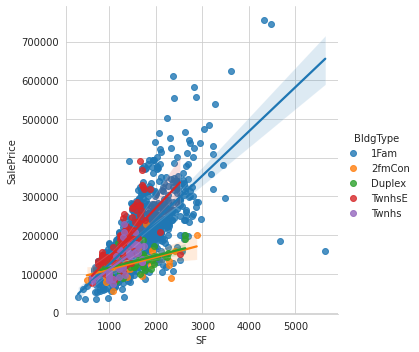

In [30]:
sns.set_style('whitegrid')
sns.lmplot(x ='SF', y ='SalePrice', data = df_house, 
           hue ='BldgType')

## Normalization
I will not cover normalization here in detail but consider that we might divide our sales price by square foot to get a price per square foot and then use Price/SF as our dependent Y variable.  

In [27]:
df_house['Price_SF']=df_house['SalePrice']/df_house['SF']
model(X=df_house[['constant','1Fam','2fmCon']], Y=df_house['Price_SF'])

                            GLS Regression Results                            
Dep. Variable:               Price_SF   R-squared:                       0.021
Model:                            GLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     15.62
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           1.95e-07
Time:                        15:16:20   Log-Likelihood:                -7078.3
No. Observations:                1460   AIC:                         1.416e+04
Df Residuals:                    1457   BIC:                         1.418e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant     120.6541      2.136     56.478      0.0

### Interpretation
After normalizing Price by Square Foot we can see that there are not any significant differences between 1Fam and the "other" cateogry.  The p-value is 0.633 and thus we fail to reject the Null.  

This adds more evidence in favor of what we have already learned; the difference in price between 1Fam and the "other" category seem to be largely driven by differences in the size of the units.  

In [28]:
# create interactions between our dummy variables and Total Square Foot
df_house['SF_1Fam']=df_house['SF']*df_house['1Fam']
df_house['SF_2fmCon'] = df_house['SF']*df_house['2fmCon']
model(X=df_house[['constant','SF','1Fam','2fmCon','SF_1Fam','SF_2fmCon']], Y=df_house['SalePrice'])

                            GLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.539
Model:                            GLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     340.1
Date:                Wed, 23 Nov 2022   Prob (F-statistic):          1.70e-241
Time:                        15:16:25   Log-Likelihood:                -17979.
No. Observations:                1460   AIC:                         3.597e+04
Df Residuals:                    1454   BIC:                         3.600e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant    7.623e+04   1.46e+04      5.223      0.0

In [ ]:
model2 = smf.ols(formula='SalePrice ~ SF', data=df_house).fit()
print(model2.summary())